# Single crystal elastic constants

The intention of this notebook is to get familiar with the methods for calculating single crystal elastic constants, $C_{ij}$. We will explore two methods, the *stress-strain* and the *energy-strain* method, both based on the Hooke's law of linear theory of elasticity.

As a calculator of the energies and stresses in this exercise we will use the DFT code Quantum Espresso.  The same methodology, however, can be applied also when the energies and stresses are calculated using, e.g. DFT-VASP or LAMMPS programs.

Let's start with some imports, as usual...

In [69]:
import numpy as np
from ase import Atoms
from ase.eos import EquationOfState
from ase.visualize import view
from ase.io import read
from ase.build import bulk
from pyace import PyACECalculator
from ase.stress import full_3x3_to_voigt_6_stress, voigt_6_to_full_3x3_stress, full_3x3_to_voigt_6_strain, voigt_6_to_full_3x3_strain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
from quippy.potential import Potential
os.environ['OMP_NUM_THREADS'] = '1'

## 1. EoS and bulk modulus of bcc-Mo

In this exercise, we will study bcc-Mo. Let's quickly do structural optimization via Birch-Murnaghan equation of state, to get the equilibrium lattice constant corresponding to our pseudopotential (and other chosen parameters), and also to get the bulk modulus $B$ for comparison and use later on.

**Task**: Perform EoS for bcc-Mo and get equilibrium lattice constant $a$ and bulk modulus $B$.

Below are definitions for the DFT calculations using QE. For details see previous exercise and/or [QE documentation](https://www.quantum-espresso.org/Doc/INPUT_PW.html).

In [70]:
diamond_struct = bulk('Si', 'diamond', a=5.431, cubic=True)

In [71]:
volumes = []
energies = []

calc = Potential(init_args='Potential xml_label="GAP_2017_6_17_60_4_3_56_165"',
                                               param_filename='gp_iter6_sparse9k.xml')
for scale in tqdm(np.linspace(0.98, 1.02, 9)):
    struct = diamond_struct.copy()
    struct.set_cell(diamond_struct.cell.array*scale, scale_atoms=True)
    struct.calc = calc
    energies.append(struct.get_total_energy())
    volumes.append(struct.get_volume())

  0%|          | 0/9 [00:00<?, ?it/s]

Let's do the B-M EoS

In [72]:
eos = EquationOfState(volumes, energies, eos="birchmurnaghan")
V0_fit, E0_fit, B0_fit = eos.fit()
a0_fit = V0_fit**(1/3)
B0_fit *= 160.2

print(f'lattice parameter is {a0_fit:.4f}Å')
print(f'bulk modulus is {B0_fit:.0f}GPa')
print(f'minimum energy is {E0_fit/2:.3f}eV/at.')

lattice parameter is 5.4609Å
bulk modulus is 88GPa
minimum energy is -652.711eV/at.


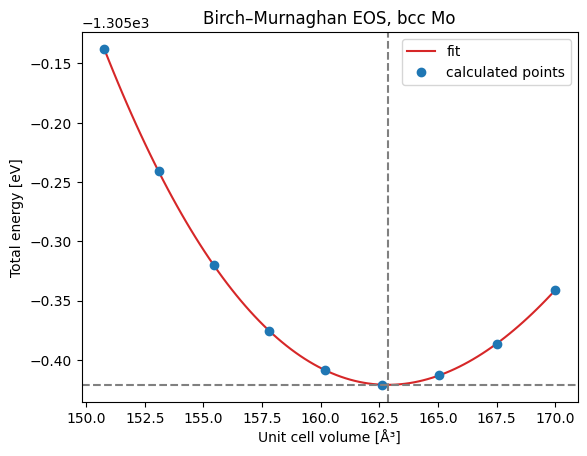

In [73]:
from matplotlib import pyplot as plt

ax = eos.plot(show=False)

ax.axvline(V0_fit, ls='--', color='gray')
ax.axhline(E0_fit, ls='--', color='gray')
ax.set_xlabel("Unit cell volume [Å³]")
ax.set_ylabel("Total energy [eV]")
ax.set_title("Birch–Murnaghan EOS, bcc Mo")
ax.legend(["fit", "calculated points"])

plt.show()

Let's redefine the equilibrium lattice cell based on EoS results

In [74]:
diamond_struct = bulk('Si', 'diamond', a=a0_fit, cubic=True)

## 1. Linear theory of elasticity

In order to fully describe the elastic response of a any material, one needs to know a tensor of elastic constants $c_{ijkl}$ which are conveniently represented by a $6\times6$ matrix of elastic constants, $\underline{\underline{C}} = C_{ij}$ (Voigt's notation). These link stress and strain tensors as described by the Hooke's law $$\underline{\sigma} = \underline{\underline{C}} \underline{\varepsilon}$$. 

For a *cubic* system (only), there are only three independent elastic constants, $C_{11}, C_{12}$ and $C_{44}$. Then, the matrix of elastic constants (in Voigt's notations), $ \underline{\underline{C}}$, has very special form, which transforms the Hooke's law into:

$$
\underbrace{\left(\begin{array}{c} 
\sigma_{xx} \\
\sigma_{yy} \\
\sigma_{zz} \\
\tau_{yz} \\
\tau_{xz} \\
\tau_{xy} 
\end{array}\right)}_{\underline{\sigma}} = 
\underbrace{\left(\begin{array}{cccccc} 
C_{11} & C_{12} & C_{12} & 0 & 0 & 0 \\
C_{12} & C_{11} & C_{12} & 0 & 0 & 0 \\
C_{12} & C_{12} & C_{11} & 0 & 0 & 0 \\
0 & 0 & 0 & C_{44} & 0 & 0 \\
0 & 0 & 0 & 0 & C_{44} & 0 \\
0 & 0 & 0 & 0 & 0 & C_{44} \\
\end{array}\right)}_{\underline{\underline{C}}}
\underbrace{\left(\begin{array}{c} 
\varepsilon_{xx} \\
\varepsilon_{yy} \\
\varepsilon_{zz} \\
\gamma_{yz} \\
\gamma_{xz} \\
\gamma_{xy} 
\end{array}\right)}_{\underline{\varepsilon}}
$$ 

*Strain energy* is calculated as
$$
E_{\text{strain}} = \int_{V_0} \int_{\underline{0}}^{\underline{\varepsilon}} \underline{\sigma}\,{\mathrm d}\underline{\varepsilon}\,{\mathrm d}V
$$
In the case of homogeneous strain/stress over the volume, $V_0$ and using the (general) Hooke's law, the above expression simplifies to
$$
E_{\text{strain}} = \frac{V_0}{2}\sum_{i,j}C_{ij}\varepsilon_i\varepsilon_j
$$

Note: The Voigt's notation uses *engineering* shear strains $\gamma_{ij}$ instead of the *physical* (tensorial) shear strains $\varepsilon_{ij}$: 
$$\gamma_{ij} = 2\varepsilon_{ij}\quad \text{for}\quad i\not=j$$
The stress shear components are the same as in both, Voigt's as well as in tensorial notation:
$$\tau_{ij}=\sigma_{ij}\quad\text{for}\quad i\not=j$$

## 2. The *strain*-*stress* method

If your DFT code is able to calculate the stress on the cell, one can use the Hooke's law directly via so-called *strain-stress* method. 
Not all codes can do so, but Quantum Espresso can. 
In principle, it is an inverse of a tensile test. 
Instead of loading the sample with a stress/force and measuring the strain/displacement, we prescribe strain $\varepsilon$ and calculate ("measure") the stress $\sigma$. They are related by the tensor of elastic constants $\underline{\underline{C}}$ through the Hooke's law:
$$
\underline{\sigma} = \underline{\underline{C}}\underline{\varepsilon} \Leftrightarrow \underline{\sigma} \underline{\varepsilon}^{-1} = \underline{\underline{C}}
$$
Consider now cubic materials with the elastic constants matrix as given above. Applying strain
$$
\underline{\varepsilon}_c = \delta
\left(\begin{array}{c} 
 1\\ 
 0\\
 0\\
 1\\
 0\\
 0
\end{array}\right)
$$ 
leads to stress in the form
$$
\underline{\sigma}_c = \delta
\left(\begin{array}{c}
 C_{11}\\
 C_{12}\\
 C_{12}\\
 C_{44}\\
 0\\
 0
\end{array}\right)
$$
and hence we can get all three independent elastic constants from a single calculation. Let's try that!

### 2.1. Elastic constants of bcc Mo

**Task**: Calculated three elastic constants of bcc Mo using the above derived formalism using a single special strain.

The *special* strain tensor to calculate cubic $C_{ij}$

In [75]:
# define strain magnitude
magnitude = 0.02
# define strain vector
voigt_strain = magnitude*np.array([ 1, 0, 0, 1, 0, 0])
# corresponding deformation matrix
strain_tensor = voigt_6_to_full_3x3_strain(voigt_strain)
strain_tensor

array([[1.02, 0.  , 0.  ],
       [0.  , 1.  , 0.01],
       [0.  , 0.01, 1.  ]])

Convenience function to apply strain to a cell

In [76]:
def apply_strain(strain_3x3_tensor, initial):
    new_cell = strain_3x3_tensor @ initial.cell.array
    deformed = initial.copy()
    deformed.set_cell(new_cell, scale_atoms=True)
    return deformed

Apply strain and check the volume change due to the strain

In [77]:
deformed = apply_strain(strain_tensor, diamond_struct)
# check volume change
deformed.get_volume()/diamond_struct.get_volume()

1.019898

Now, let's do the actual DFT calculation

In [78]:
#attach it to the structure
deformed.calc = calc

stress = deformed.get_stress() * 160.22 # convert to eV/A^3 to GPa
print('Stress vector:', stress)

# double check we have the equilibrium lattice parameter mostly correct, should have stress close to zero
diamond_struct.calc=calc
print('Stress vector of relaxed cell:', diamond_struct.get_stress())

# recalculate strain back
strain = np.dot(deformed.cell.array, np.linalg.inv(diamond_struct.cell.array))
strain = full_3x3_to_voigt_6_strain(strain)
print('Strain vector:', strain)

Stress vector: [ 2.97502770e+00  1.00773693e+00  1.00773693e+00  1.85039760e+00
 -1.05472191e-14 -9.56840521e-15]
Stress vector of relaxed cell: [ 4.13720283e-06  4.13720283e-06  4.13720283e-06 -3.29985943e-16
 -3.00937305e-16 -2.93406350e-16]
Strain vector: [0.02 0.   0.   0.02 0.   0.  ]


Now, let's get the elastic constants

In [79]:
print(f'C11 = {stress[0]/strain[0]:.1f} GPa')
print(f'C12 = {stress[1]/strain[0]:.1f} GPa')
print(f'C44 = {stress[3]/strain[3]:.1f} GPa')

C11 = 148.8 GPa
C12 = 50.4 GPa
C44 = 92.5 GPa


Here is a table of elastic constants from literature for comparison:

<center>
<img <img src="https://www.researchgate.net/publication/340865533/figure/tbl1/AS:883463238451201@1587645458152/Bulk-elastic-constants-of-cubic-crystals-unit-GPa_W640.jpg" /> />
</center>

Let us check the value of the bulk modulus
$$ B = \frac{1}{3} (C_{11} + 2 C_{12})$$
The above literature data yield 262 GPa, from the EoS we got 255 GPa. From this single-shot stress-strain DFT calculation we get:

In [80]:
print(f'B = {(1/3)*(stress[0]/strain[0] + 2*stress[1]/strain[0]):.1f} GPa')

B = 83.2 GPa


The elastic response is clearly softer than expected, on the other hand not too bad for the fact that we got the full description from a *single* calculation. But we can do even better.

### 2.2. ULICS

To increase universality (other than cubic symmetries) but equally important also the numerical stability of the method, it is convenient to loads the unit cell with 6 linearly independent special strains (termed *universal linear-independent coupling strains*, ULICS) in tension and compression, leading to overall 12 deformations (R. Yu, J. Zhu, and H. Ye, *Comput. Phys. Commun.* **181**, 671 (2010)). The strains used are:
$$
\underline{\varepsilon}_1 = \pm\frac{\delta}{6}
\left(\begin{array}{c} 
 1\\ 
 -2\\
 3\\
 -4\\
 5\\
 -6
\end{array}\right), \;\; 
\underline{\varepsilon}_2 = \pm\frac{\delta}{6}
\left(\begin{array}{c} 
 2\\
 1\\
-5\\
-6\\
 4\\
 3
\end{array}\right), \;\; 
\underline{\varepsilon}_3 = \pm\frac{\delta}{6}
\left(\begin{array}{c} 
 3\\
 4\\
-1\\
 5\\
 5\\
-2
\end{array}\right), \;\; 
\underline{\varepsilon}_4 = \pm\frac{\delta}{6}
\left(\begin{array}{c} 
4\\
-3\\
 6\\
 1\\
-2\\
 5
\end{array}\right), \;\; 
\underline{\varepsilon}_5 = \pm\frac{\delta}{6}
\left(\begin{array}{c} 
5\\
 6\\
 2\\
-3\\
-1\\
-4
\end{array}\right), \;\; 
\underline{\varepsilon}_6 = \pm\frac{\delta}{6}
\left(\begin{array}{c} 
6\\
-5\\
-4\\
 2\\
-3\\
 1
\end{array}\right), \;\; 
$$
where $\delta$ is the magnitude of the strain. We often use $0.01<\delta<0.025$ which usually ensures the linear-elastic regime (found by trial and error). Here we will use a value $\delta = 0.02$.
As a result we obtain then 12 different strain vectors corresponding 12 stress vectors, however, all connected by the same matrix of elastic constants.
Due to numerical errors and the strain matrix shape, an exact inverse of strain matrix does not exist, and hence we use so called *Moore-Penrose* pseudoinverse instead.
$$\underline{\underline{C}} = \underline{\underline{S}}\underline{\underline{E}}^{-1}$$
where $\underline{\underline{S}} = (\underline{\sigma}_1 \underline{\sigma}_2 \dots \underline{\sigma}_{12})$ and $\underline{\underline{E}}=(\underline{\varepsilon}_1\underline{\varepsilon}_2\dots\underline{\varepsilon}_{12})$.

**Task**: Recalculate $C_{ij}$ of bcc-Mo with the stress-strain method employing ULICS. Use the maximum magnitude of $0.02$.

Let's define a function providing the ULICS

In [81]:
def get_ULICS(max_eps: float = 1.5e-2) -> np.ndarray:
    """
    Returns ULICS (universal linear-independent coupling strains) used
    for deformations in the stress-strain method.

    For details, refer to doi:10.1016/j.cpc.2009.11.017.

    Parameters
    ----------
    max_eps : float, optional
        Magnitude of the stress (largest component in Voigt's notation).
        Defaults to 1.5e-2.

    Returns
    -------
    numpy.ndarray
        6x6 matrix of ULICS.
    """
    # Creating the 6x6 matrix of ULICS
    ULICS = max_eps / 6.0 * np.array([
        [1, -2, 3, -4, 5, -6],
        [2, 1, -5, -6, 4, 3],
        [3, 4, -1, 5, 6, -2],
        [4, -3, 6, 1, -2, 5],
        [5, 6, 2, -3, -1, -4],
        [6, -5, -4, 2, -3, 1]
    ], dtype=np.float64)

    return ULICS

In [82]:
# define strain magnitude
magnitude = 0.02
# define strain vector
strains = get_ULICS(max_eps=magnitude)
# strains = [sign*magnitude*s for sign in (-1, 1) for s in strains]
strains = np.concatenate((strains, -strains))
print(strains)

[[ 0.00333333 -0.00666667  0.01       -0.01333333  0.01666667 -0.02      ]
 [ 0.00666667  0.00333333 -0.01666667 -0.02        0.01333333  0.01      ]
 [ 0.01        0.01333333 -0.00333333  0.01666667  0.02       -0.00666667]
 [ 0.01333333 -0.01        0.02        0.00333333 -0.00666667  0.01666667]
 [ 0.01666667  0.02        0.00666667 -0.01       -0.00333333 -0.01333333]
 [ 0.02       -0.01666667 -0.01333333  0.00666667 -0.01        0.00333333]
 [-0.00333333  0.00666667 -0.01        0.01333333 -0.01666667  0.02      ]
 [-0.00666667 -0.00333333  0.01666667  0.02       -0.01333333 -0.01      ]
 [-0.01       -0.01333333  0.00333333 -0.01666667 -0.02        0.00666667]
 [-0.01333333  0.01       -0.02       -0.00333333  0.00666667 -0.01666667]
 [-0.01666667 -0.02       -0.00666667  0.01        0.00333333  0.01333333]
 [-0.02        0.01666667  0.01333333 -0.00666667  0.01       -0.00333333]]


Now, let's do the DFT calculations and collect stresses

In [83]:
data = []
for i, strain in enumerate(tqdm(strains)):
    # DFT caclulations are slow, so first check if the calculation is already done
    # try to read the espresso.pwo output file with ase.io.read
    deformed = apply_strain(voigt_6_to_full_3x3_strain(strain), diamond_struct)
    deformed.calc = calc
    stress = deformed.get_stress() * 160.22
    data.append((strain, stress))

  0%|          | 0/12 [00:00<?, ?it/s]

Let's calculated the matrix $C_{ij}$ using the pseudoinverse

In [84]:
epsilon, sigma = list(zip(*data)) 
epsilon, sigma = map(np.array, (epsilon, sigma))
Cij = np.matmul(np.linalg.pinv(epsilon), sigma)

# Symmetrize the result
Cij = 0.5*(Cij + Cij.T)
print(np.array2string(Cij, formatter={'float': lambda x: f"{x:4.2f}"}))

[[150.58 57.99 58.15 -0.03 -0.09 -0.01]
 [57.99 150.29 58.30 -0.08 0.08 -0.12]
 [58.15 58.30 150.42 -0.08 0.00 0.05]
 [-0.03 -0.08 -0.08 97.19 -0.10 0.11]
 [-0.09 0.08 0.00 -0.10 97.14 0.16]
 [-0.01 -0.12 0.05 0.11 0.16 97.22]]


As you can see, $C_{11} \ne C_{12} \ne C_{13}$ (and the $C_{14}$, etc. element are not exactly zero) due to small numerical inaccuracies.
Those should decrease with increasing number of $k$-points, cutoff energy or better convergence threshold.
At this point we can average by projecting on cubic symmetry (to get just $C_{11}$, $C_{12}$ and $C_{44}$) or we can use the full 6x6 tensor to calculate elastic modulus (in a polystalline approximation) as we would do for a triclinic crystal.

In [85]:
def project_cubic(cij: np.ndarray) -> np.ndarray:
    """
    Computes to Cij tensor projected to cubic symmetry

    :param cij: array of shape (6,6) the raw elasticity tensor
    :type cij: NDArray
    :return: the projected Cij tensor
    :rtype: NDArray
    """
    cij = np.array(cij)
    projected_cij = np.zeros((6, 6))
    projected_cij[0, 0] = np.around(np.mean([cij[i, i] for i in np.arange(3)]), 2)
    for i in np.arange(1, 3):
        projected_cij[i, i] = projected_cij[0, 0]
    projected_cij[3, 3] = np.around(np.mean([cij[i, i] for i in np.arange(3, 6)]), 2)
    for i in np.arange(4, 6):
        projected_cij[i, i] = projected_cij[3, 3]
    projected_cij[1, 0] = np.around(np.mean([cij[1, 0], cij[2, 0], cij[2, 1]]), 2)
    projected_cij[2, 0] = projected_cij[1, 0]
    projected_cij[2, 1] = projected_cij[1, 0]
    projected_cij[0, 1] = projected_cij[1, 0]
    projected_cij[0, 2] = projected_cij[1, 0]
    projected_cij[1, 2] = projected_cij[1, 0]
    return projected_cij

print("Cubic-projected Cij tensor:")
projectedCij = project_cubic(Cij)
print(np.array2string(project_cubic(Cij), formatter={'float': lambda x: f"{x:4.2f}"}))

# Also print the bulk modulus
print(f'B = {(1/3)*projectedCij[0,0] + (2/3)*projectedCij[0,1]:.1f} GPa')

Cubic-projected Cij tensor:
[[150.43 58.15 58.15 0.00 0.00 0.00]
 [58.15 150.43 58.15 0.00 0.00 0.00]
 [58.15 58.15 150.43 0.00 0.00 0.00]
 [0.00 0.00 0.00 97.18 0.00 0.00]
 [0.00 0.00 0.00 0.00 97.18 0.00]
 [0.00 0.00 0.00 0.00 0.00 97.18]]
B = 88.9 GPa


Obviously, these values are much closer to the previously reported literature data (check the table above!)

A nice tool to do this as well as some further analysis like anisotropy is [elate](https://progs.coudert.name/elate) web interface. Below we print the as calculated symmetrized $C_{ij}$ data in a format suitable for copy&paste into [elate](https://progs.coudert.name/elate).

In [86]:
print("Full Cij tensor:")
# print just the 6x6 Cij values (no brackets) so we can copy-paste directly into elate
for row in Cij:
    print(" ".join(f"{val:8.2f}" for val in row))

print(Cij)

Full Cij tensor:
  150.58    57.99    58.15    -0.03    -0.09    -0.01
   57.99   150.29    58.30    -0.08     0.08    -0.12
   58.15    58.30   150.42    -0.08     0.00     0.05
   -0.03    -0.08    -0.08    97.19    -0.10     0.11
   -0.09     0.08     0.00    -0.10    97.14     0.16
   -0.01    -0.12     0.05     0.11     0.16    97.22
[[ 1.50583972e+02  5.79860642e+01  5.81523343e+01 -2.73910848e-02
  -9.37674282e-02 -7.55372660e-03]
 [ 5.79860642e+01  1.50287565e+02  5.83046440e+01 -8.28437085e-02
   8.08642188e-02 -1.20040280e-01]
 [ 5.81523343e+01  5.83046440e+01  1.50423072e+02 -8.35815074e-02
   1.69115827e-03  5.30195326e-02]
 [-2.73910848e-02 -8.28437085e-02 -8.35815074e-02  9.71925383e+01
  -9.58670779e-02  1.08863859e-01]
 [-9.37674282e-02  8.08642188e-02  1.69115827e-03 -9.58670779e-02
   9.71416115e+01  1.64993434e-01]
 [-7.55372660e-03 -1.20040280e-01  5.30195326e-02  1.08863859e-01
   1.64993434e-01  9.72206754e+01]]


## 3. The *energy*-*strain* method for cubic materials

The energy increase upon straining the system may be obtained by inserting the above Hooke's law into
$$E_{\text{strain}} = \frac{V}{2} \sum_{i,j}\sigma_i\varepsilon_j =  \frac{V}{2} \underline{\varepsilon}^T \underline{\underline{C}} \underline{\varepsilon}.$$

Now, consider *orthorhombic* and *monoclinic* deformations with a magnitude $\delta$, which have form:
$$
\varepsilon_{\text{orthorhombic}} = 
\left(\begin{array}{c} 
\delta \\
-\delta \\
\frac{\delta^2}{1-\delta^2} \\
0 \\
0 \\
0 
\end{array}\right) \;\;\;\; 
\varepsilon_{\text{monoclinic}} = 
\left(\begin{array}{c} 
0 \\
0 \\
\frac{4}{4-\delta^2} \\
0 \\
0 \\
\delta
\end{array}\right) 
$$
We ask `sympy` for help with the evaluation of the strain energy for cubic systems. For other symmetries, the matrix of stiffness constants would take a different shape.

In [87]:
from sympy import Matrix, symbols, simplify, S

C11, C12, C44, delta = symbols('C_11 C_12 C_44 delta')
C = Matrix([
    [C11, C12, C12, 0, 0, 0],
    [C12, C11, C12, 0, 0, 0],
    [C12, C12, C11, 0, 0, 0],
    [0, 0, 0, C44, 0, 0],
    [0, 0, 0, 0, C44, 0],
    [0, 0, 0, 0, 0, C44]
])
strain_orth = Matrix([
    [delta, -delta, delta**2/(1-delta**2), 0, 0 ,0]
]).T
strain_mono = Matrix([
    [0, 0, delta**2/(4-delta**2), 0, 0, delta]
]).T

In [88]:
strain_energy = S('1/2')*(C*strain_orth).T*strain_orth
simplify(strain_energy)

Matrix([[C_11*delta**4/(2*(delta**2 - 1)**2) + C_11*delta**2 - C_12*delta**2]])

Therefore we immeadeately see that for the orthorhombic deformation described by strain $\varepsilon_{\text{orthorhombic}}$, the strain energy of a cubic system is $$E_{\text{strain}} = (C_{11}-C_{12})\delta^2 + \mathcal{O}(\delta^4).$$
Similarly, the strain energy for $\varepsilon_{\text{monoclinic}}$ gives directly $C_{44}$ for a cubic system.

In [89]:
strain_energy = S('1/2')*(C*strain_mono).T*strain_mono
simplify(strain_energy)

Matrix([[C_11*delta**4/(2*(delta**2 - 4)**2) + C_44*delta**2/2]])

### 3.1. $C_{11}$ and $C_{12}$ from orthorhombic deformation mode

Let's calculate energies for a couple values of $\delta$ and then fit the results with quadratic function

In [90]:
data = []
for i, delta in enumerate(tqdm(np.linspace(-0.010, 0.010, 9))):
    # generate the strain vector
    voigt_strain = np.array([delta, -delta,  delta**2/(1-delta**2), 0, 0, 0])
    strain = voigt_6_to_full_3x3_strain(voigt_strain)
    # DFT calculations are slow, so first check if the calculation is already done
    # try to read the espresso.pwo output file with ase.io.read
    deformed = apply_strain(strain, diamond_struct)
    deformed.calc = calc
    energy = deformed.get_total_energy()
    data.append(dict(delta=delta, energy=energy))

data = pd.DataFrame(data)
data.head()

  0%|          | 0/9 [00:00<?, ?it/s]

,delta,energy
0,-0.0100,-1305.411856
1,-0.0075,-1305.415879
2,-0.0050,-1305.418747
3,-0.0025,-1305.420466
4,0.0000,-1305.421038


define a quadratic function for fitting

In [91]:
quad_fit = np.polyfit(data['delta'], data['energy'], deg=2)
quad_fit

array([ 9.18266264e+01, -1.33853398e-08, -1.30542104e+03])

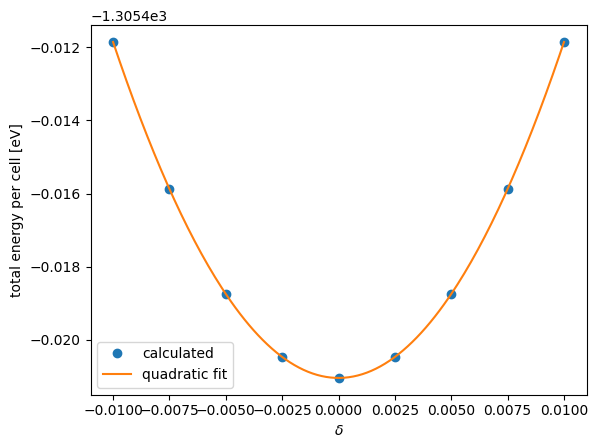

In [92]:
# plot data and the fit
x_axis = np.linspace(data['delta'].min(), data['delta'].max(), num=200)
plt.plot(data['delta'], data['energy'], 'o', label='calculated')
plt.plot(x_axis, np.polyval(quad_fit, x_axis), label='quadratic fit')
plt.xlabel("$\\delta$"),
plt.ylabel("total energy per cell [eV]")
plt.legend()
plt.show()

From this fit, we get $C_{11}-C_{12}$:

In [93]:
# get elastic constants
C11C12 = quad_fit[0]/diamond_struct.cell.volume*160.2
C11C12

90.32990606190738

Finally, we solve a system of two linear equations, to get the constants $C_{11}$ and $C_{12}$:
$$
C_{11}+2C_{12}=3B0\_fit\quad,\quad
C_{11}-C_{12} = C11C12
$$

In [94]:
from sympy import linsolve

linsolve([C11+2*C12-3*B0_fit, C11-C12-C11C12], C11, C12)

{(148.388692688894, 58.0587866269868)}

Compare those resultes with stress-strain and literature data

In [95]:
print(projectedCij[0,0], projectedCij[0,1])

150.43 58.15


Literature data for comparison:

<center>
<img <img src="https://www.researchgate.net/publication/340865533/figure/tbl1/AS:883463238451201@1587645458152/Bulk-elastic-constants-of-cubic-crystals-unit-GPa_W640.jpg" />
</center>

We see that all those results are consistent, which is how it should be (since they are all based on the same theory), but it is still comforting to see so :-)

### 3.2. $C_{44}$ from the moniclinic deformation mode 

**Task**: Repeat essentially the same exercise as above, but this time using the moniclinic deformation mode.

Use the energy strain method to calculate $C_{44}$ from a quadratic fit to the total energy of the form
$$
    \frac1{V_0} (E(\delta)-E_0) = \frac12C_{44}\delta^2
$$
where $\delta$ describes the monoclinic deformation of the form (in Voigt's notation):
$$
    \varepsilon_{\text{monoclinic}} = \left(\begin{array}{c} 0 \\ 0 \\ \frac{\delta^2}{4-\delta^2} \\ 0 \\ 0 \\ \delta \end{array}\right).
$$

In [96]:
data = []
for i, delta in enumerate(tqdm(np.linspace(-0.010, 0.010, 9))):
    # generate the strain vector
    voigt_strain = np.array([ 0, 0,  delta**2/(4-delta**2), 0, 0, delta])
    strain = voigt_6_to_full_3x3_strain(voigt_strain)
    # DFT calculations are slow, so first check if the calculation is already done
    # try to read the espresso.pwo output file with ase.io.read
    deformed = apply_strain(strain, diamond_struct)
    deformed.calc = calc
    energy = deformed.get_total_energy()
    data.append(dict(delta=delta, energy=energy))

data = pd.DataFrame(data)
data.head()

  0%|          | 0/9 [00:00<?, ?it/s]

,delta,energy
0,-0.0100,-1305.416159
1,-0.0075,-1305.418294
2,-0.0050,-1305.419819
3,-0.0025,-1305.420733
4,0.0000,-1305.421038


define a quadratic function for fitting

In [97]:
quad_fit_C44 = np.polyfit(data['delta'], data['energy'], deg=2)
quad_fit_C44

array([ 4.87904958e+01,  7.94901318e-08, -1.30542104e+03])

plot data and the fit

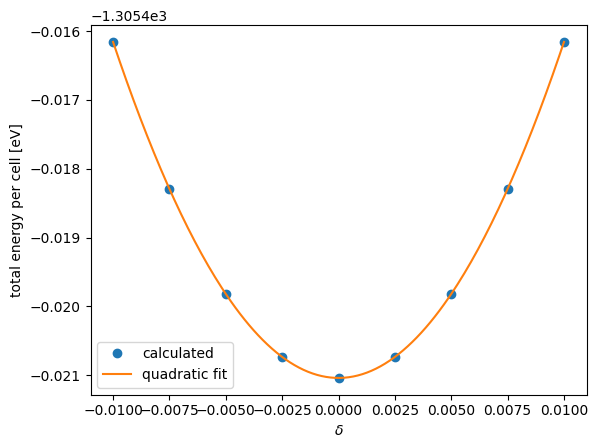

In [98]:
x_axis = np.linspace(data['delta'].min(), data['delta'].max(), num=200)
plt.plot(data['delta'], data['energy'], 'o', label='calculated')
plt.plot(x_axis, np.polyval(quad_fit_C44, x_axis), label='quadratic fit')
plt.xlabel("$\\delta$"),
plt.ylabel("total energy per cell [eV]")
plt.legend()
plt.show()

Extract the $C_{44}$ elastic constant and compare it with the results from the stress-strain method and literature

In [99]:
2*quad_fit_C44[0]/diamond_struct.cell.volume*160.2

95.99047840730586

In [100]:
# compare with the stress-strain method
projectedCij[3,3]

97.18

Literature data for comparison:

<center>
<img <img src="https://www.researchgate.net/publication/340865533/figure/tbl1/AS:883463238451201@1587645458152/Bulk-elastic-constants-of-cubic-crystals-unit-GPa_W640.jpg" />
</center>